# Tekstidokumenttien luokittelu
Tässä työkirjassa esitellään luonnollisen kielen prosessointiin (NLP) perustuvaa tekstidokumenttien luokittelua. Olen kirjoittanut työkirjan perehdytysmateriaaliksi työyhteisöni jäsenille, jotka ovat kiinnostuneita koneoppimisesta ja luonnollien kielen käsittelystä, mutta joilla ei ole niistä aiempaa kokemusta. Tavoitteenani on auttaa heitä saavuttamaan perustason ymmärrys, mistä asiassa on kyse ja samalla mahdollisesti kannustaa kokeilemaan myös itse. Työkirjaa voi halutesaan huoletta lukea hyppäämällä koodiosuuksien yli. Koodin ymmärtäminen ei ole välttämätöntä tekstidoumenttien luokittelun perusteiden ymmärtämisen kannalta.

Luonnollisella kielellä tarkoitetaan kieltä, jonka alkuperää ei tiedetä (esim. suomi, ruotsi, englanti). Vastaavasti esimerkiksi ohjelmointikielet ovat keinotekoisia kieliä. 

Luokittelussa käytetään ohjattua koneoppimista. Ohjatussa oppimisessa tarvitaan aina mahdollisimman hyvin todellisuutta vastaava, riittävän suuri koulutusaineisto, jossa jokaiselle koulutusaineiston esimerkille on talletettu myös sen oikean luokan arvo. Koulutuksen aikana koneoppimisalgoritmi optimoi ennustemallin sovittamalla sen koulutusaineistoon. Tavoitteena on, että tuloksena saatava malli osaisi mahdollisimman luotettavasti ennustaa oikean luokan sellaisille dokumenteille, joita se ei ole opetusvaiheessa nähnyt.

Työkirjan alkuosassa hyödynnetään tavallisella kannettavalla Windows-koneella (ei grafiikkasuoritinta, GPU) helposti käyttöönotettavia luonnollisen kielen prosessointiin kehitettyjä Python-koneoppimiskirjastoja. Nämä kirjastot on helppo ladata omalle tietokoneelle esimerkiksi osana open-source Anaconda-jakelua (https://www.anaconda.com/distribution/). 

Myös yksinkertaisia neuroverkkoja on mahdollista opettaa tavallisella kotikoneella. Suurten datamäärien ja syvempien neuroverkkojen kouluttaminen vaatii kuitenkin muistia ja laskentakapasiteettia peruskotikonetta enemmän. Työkirjan lopussa hyödynnetäänkin neuroverkkojen kouluttamiseen CSC:n yliopistoille tarjoamaa Puhti-supertietokonetta (https://www.csc.fi/-/supertietokone-puhti-on-avattu-tutkijoiden-kayttoon).

Työkirja on tehty käyttäen interaktiivista Jupyter Notebookia (https://jupyter.org/), joka on selaimella käytettävä ohjelmointityökalu. Myös Jupyter Notebook asentuu automaattisesti osana Anaconda-jakelua. Työkirjaa voi joko lukea valmiina dokumenttina tai sen koodisoluja voi (muokata ja) ajaa itse, jolloin uudet ajotulokset korvaavat vanhat.


## 1. Käytetyt kirjastot
Kaikki työkirjassa käytetyt Python-kirjastot on kerätty tähän työkirjan alkuun, jotta ne olisi kätevästi ladatattavissa keskusmuistiin, heti kun työkirja avataan. 

Tällä hetkellä Pythonin uusin versio on 3.8.0, joka on julkaistu 14.10.2019 (https://www.python.org/downloads/release/python-380/).  Kuitenkin monipuolinen luonnollisen kielen käsittelyyn kehitetty NLTK-kirjasto toimii korkeintaan Pythonin versiolla 3.7 (https://www.nltk.org/install.html) ja neuroverkkojen opettamiseen kehitetty Keras on yhteensopiva vain Pythonin versioiden 2.7-3.6 kanssa (https://keras.io/). Siksi käytän työkirjan alkuosassa Pythonin versiota 3.7 ja loppuosassa versiota 3.6. Käytännössä minulla on siis Anacondan avulla asennettuna kaksi ympäristöä, joista valitsen sopivan jo ennen työkirjan (Jupyter Notebook) avaamista. Kun haluan vaihtaa toiseen ympäristöön, suljen työkirjan, valitsen Anacondassa uuden ympäristön ja avaan siitä ympäristöstä työkirjan uudelleen. Tämän jälkeen ajan työkirjan alusta vain siinä ympäristössä käyttämäni kirjastot.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
# käytän Python 3.7.0 kanssa
import nltk
# nltk.download('punkt') täytyy ladata vain kertaalleen

In [3]:
# käytän Python 3.6.8 kanssa, koska yhteentoimivuutta ei luvata uudempien versioiden kanssa.
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#import gensim

Using TensorFlow backend.


Jotta en pidempien taukojen jälkeen joutuisi aloittamaan aina koko työkirjan ajamista alusta, olen lisännyt tähän alkuun myös tärkeiden myöhemmässä vaiheessa laskettavien vektoreiden lataamisen muistista. 

In [12]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_dev = np.load('X_dev.npy')
y_dev = np.load('y_dev.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

labels_train = np.load('labels_train.npy')
labels_dev = np.load('labels_dev.npy')
labels_test = np.load('labels_test.npy')

Xpad_train = np.load('Xpad_train.npy')
Xpad_dev = np.load('Xpad_dev.npy')
Xpad_test = np.load('Xpad_test.npy')

embmatrix = np.load('embmatrix.npy')
embmatrix_all = np.load('embmatrix_all.npy')


## 2. Luokitteluun käytettävä data
Demodatana käytetään Kielipankin CC-BY-NC 4.0 lisenssillä jakamaa Ylilauta-korpusta (http://urn.fi/urn:nbn:fi:lb-2016101210), jota Turun yliopiston kieli- ja puheteknologian apulaisprofessori Sampo Pyysalo on edelleen muokannut yksinkertaiseen (aihe, teksti) TSV-muotoon ja tuottanut siitä menetelmien vertailuun tasapainotetun kymmenen luokan datasetin. Käytetty aineisto on saatavilla täältä: https://github.com/spyysalo/ylilauta-corpus.

Ylilauta on anonyymi keskustelufoorumi, joka ei vaadi rekisteröitymistä tai nimimerkin käyttöä. Foorumi löytyy osoitteesta https://ylilauta.org/. Ylilauta-korpukseen on tallennettu kyseisen keskustelufoorumin keskustelupalstoja vuosilta 2014-2016. Tässä työssä käytettävään suppeampaan aineistoon on otettu sama määrä viestejä kymmenestä yleisimmin esiintyvästä aiheluokasta. Nämä aiheluokat ovat:
1. Ajoneuvot
2. Hikky (Hikikomero, masentuneiden ja sosiaalisesti syrjäytyneiden vertaistukiryhmä)
3. Kuntosali
4. Muoti
5. Pelit
6. Penkkiurheilu
7. Politiikka
8. Seksulaalisuus
9. Sota
10. Televisio            

Aineisto on jaettu valmiiksi kolmeen osaan:
* Koulutusdata erilaisten mallien kouluttamiseen: ylilauta-train.txt (10 000 kpl/aihe, yht 100.000 kpl)
* Validointidata mallien parametrien optimoimiseen ja keskinäiseen vertailuun, jotta voidaan valita näistä paras: ylilauta-dev.txt (1 000 kpl/ aihe, yhteensä 10 000 kpl)
* Testidata, jota käytetään parhaimmaksi valitun mallin luotettavuuden arviointiin: ylilauta-test.txt (1 000 kpl/ aihe, yhteensä 10 000 kpl)

Koska käytämme validointiaineistoa hyperparametrien optimoimiseen ja parhaan mallin valitsemiseen, on syytä testata parhaan mallin luotettavuus aina täysin erillisellä testidatalla.

Luetaan ensin kaikki kolme aineistoa datakehikoihin (Panda's dataframe: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). Data tallentuu alkuperäisessä muodossaan sarakkeeseen 'original'. Tämän jälkeen erotetaan alkuperäisestä tekstistä erikseen aiheet (sarakkeeseen 'label') ja varsinaiset dokumenttien sisältötekstit (sarake 'text'). Varmistetaan myös viestien lukumäärät aiheittain.

### 2.1 Koulutusdata

In [4]:
# luetaan data alkuperäisessä muodossaan ensimmäiseen sarakkeeseen (sarake numero 0):
df_train = pd.read_csv('ylilauta-train.txt', sep='\n', header = None)
# erotetaan aihe eli luokka toiseen sarakkeeseen (sarake numero 1):
df_train[1] = df_train[0].apply(lambda x: x.split()[0].split('_')[4].strip())
# erotetaan sisältöteksti kolmanteen sarakkeeseen (sarake numero 2):
df_train[2] = df_train[0].str.split(n=1).str[1]
# annetaan sarakkeille nimet:
df_train.columns = ['original','label','text']
# tulostetaan 10 ensimmäistä riviä:
print(df_train.head(10))
# tulostetaan datakehikon muoto (100000 riviä, 3 saraketta):
df_train.shape

                                            original       label  \
0  __label__ajoneuvot Kattokaas bemarijonnet tää ...   ajoneuvot   
1  __label__pelit http://www.gamespot.com/article...       pelit   
2  __label__sota Miehittäjiä vastaan taistelevien...        sota   
3  __label__ajoneuvot Sen jälkeen kun ST1 osti Sh...   ajoneuvot   
4  __label__muoti Toisiksi alin vasemmalta näyttä...       muoti   
5  __label__politiikka Väität , että perinteisest...  politiikka   
6  __label__sota varmaa toi heppatyttö kersantti ...        sota   
7  __label__kuntosali Tässä langassa kuvailemme t...   kuntosali   
8  __label__politiikka Lisään vain , että mitään ...  politiikka   
9  __label__sota En tiedä miten edes olisi mahdol...        sota   

                                                text  
0  Kattokaas bemarijonnet tää , ei taida teidän 3...  
1  http://www.gamespot.com/articles/e3-2014-why-x...  
2  Miehittäjiä vastaan taistelevien tahojen tavoi...  
3  Sen jälkeen kun ST1 osti She

(100000, 3)

In [5]:
df_cat = df_train.astype('category')
df_cat['label']
print('Viestien lukumäärät aiheittain:')
print(df_train["label"].value_counts())

Viestien lukumäärät aiheittain:
seksuaalisuus    10000
ajoneuvot        10000
hikky            10000
pelit            10000
politiikka       10000
televisio        10000
sota             10000
penkkiurheilu    10000
kuntosali        10000
muoti            10000
Name: label, dtype: int64


### 2.2 Validointidata

In [6]:
df_dev = pd.read_csv('ylilauta-dev.txt', sep='\n', header = None)
df_dev[1] = df_dev[0].apply(lambda x: x.split()[0].split('_')[4].strip())
df_dev[2] = df_dev[0].str.split(n=1).str[1]
df_dev.columns = ['original','label','text']
print(df_dev.head(10))
df_dev.shape

                                            original          label  \
0  __label__ajoneuvot Polttoöljyn tankkaaminen ja...      ajoneuvot   
1  __label__kuntosali Voi mahoton ! Täällähän on ...      kuntosali   
2  __label__penkkiurheilu Mutta tää peli on kyllä...  penkkiurheilu   
3  __label__kuntosali Ei tosta kyllä olympia-taso...      kuntosali   
4  __label__sota Jep , tota ei meenaa pikkasenkaa...           sota   
5  __label__pelit 3-4 päivää oli jonotusta ja lag...          pelit   
6  __label__muoti Tuo fraasi on jo yleinen vitsi ...          muoti   
7  __label__politiikka >Oletko sinä erityisen arv...     politiikka   
8  __label__televisio Seuraako muut nyymit tätä s...      televisio   
9  __label__sota Jahas , niin kai sitten . Onko k...           sota   

                                                text  
0  Polttoöljyn tankkaaminen ja jopa sillä ajamine...  
1  Voi mahoton ! Täällähän on jälleen vanha kunno...  
2  Mutta tää peli on kyllä väsynyt paska , eilen ... 

(10000, 3)

In [7]:
df_cat = df_dev.astype('category')
df_cat['label']
print('Viestien lukumäärät aiheittain:')
print(df_dev["label"].value_counts())

Viestien lukumäärät aiheittain:
kuntosali        1000
politiikka       1000
hikky            1000
penkkiurheilu    1000
televisio        1000
sota             1000
muoti            1000
seksuaalisuus    1000
ajoneuvot        1000
pelit            1000
Name: label, dtype: int64


### 2.3 Testidata

In [8]:
df_test = pd.read_csv('ylilauta-test.txt', sep='\n', header = None)
df_test[1] = df_test[0].apply(lambda x: x.split()[0].split('_')[4].strip())
df_test[2] = df_test[0].str.split(n=1).str[1]
df_test.columns = ['original','label','text']
print(df_test.head(10))
df_test.shape

                                            original          label  \
0  __label__politiikka Kyllä kai tyypillinen kapi...     politiikka   
1  __label__sota En suosittele sinne menemistä as...           sota   
2  __label__hikky Tiedän yhden jampan joka on mui...          hikky   
3  __label__penkkiurheilu No vaa kuka molaroi gam...  penkkiurheilu   
4  __label__sota Tässä pitää tietää , että nuo lä...           sota   
5  __label__penkkiurheilu Voidaan siirtyä neutraa...  penkkiurheilu   
6  __label__seksuaalisuus >Exällä oli liian iso m...  seksuaalisuus   
7  __label__politiikka >ok puukottaa toi tehtaanj...     politiikka   
8  __label__politiikka Juutalaistyylinen tapa jyr...     politiikka   
9  __label__muoti luultavasti babby ' s first haj...          muoti   

                                                text  
0  Kyllä kai tyypillinen kapitalisti ( yrittäjä )...  
1  En suosittele sinne menemistä asenteella mitäh...  
2  Tiedän yhden jampan joka on muinoin käyttänyt ... 

(10000, 3)

In [9]:
df_cat = df_test.astype('category')
df_cat['label']
print('Viestien lukumäärät aiheittain:')
print(df_test["label"].value_counts())

Viestien lukumäärät aiheittain:
kuntosali        1000
politiikka       1000
hikky            1000
penkkiurheilu    1000
televisio        1000
sota             1000
muoti            1000
seksuaalisuus    1000
ajoneuvot        1000
pelit            1000
Name: label, dtype: int64


## 3 Datasettien tokenisointi ja vektorisointi
Koneoppimismenetelmät eivät osaa hyödyntää tekstimuotoista dataa sellaisenaan. Jotta luonnollista kieltä voitaisiin analysoida ja käsitellä koneoppimismenetelmin, siitä on ensin johdettava numeerisia vektorimuotoisia piirteitä. 

### 3.1 Tokenisointi NLTK-kirjaston avulla
Ensimmäinen vaihe on tekstin tokenisointi, eli tekstin jakaminen sanoihin. Tokenisointiin voi käyttää esim. Natural Language Toolkit (NLTK)-kirjastosta löytyvää word_tokenize metodia. NLTK-kirjaston käyttöä on opetettu kattavasti kirjassa Natural Language Processing with Python – Analyzing Text with the Natural Language Toolkit, jonka ovat kirjoittaneet Steven Bird, Ewan Klein, and Edward Loper. Kirja on luettavissa kokonaisuudessaan osoitteessa https://www.nltk.org/book/.

In [10]:
df_train['tokenized'] = df_train['text'].apply(nltk.word_tokenize)

In [11]:
print('Ensimmäinen viesti ennen tokenisointia:\n', df_train['text'][0], '\n')
print('ja tokenisoinnin jälkeen:\n', df_train['tokenized'][0])

Ensimmäinen viesti ennen tokenisointia:
 Kattokaas bemarijonnet tää , ei taida teidän 316 tarjota ihan näin tasasta kyytiä . :D 

ja tokenisoinnin jälkeen:
 ['Kattokaas', 'bemarijonnet', 'tää', ',', 'ei', 'taida', 'teidän', '316', 'tarjota', 'ihan', 'näin', 'tasasta', 'kyytiä', '.', ':', 'D']


Jotta esim. Kissa ja kissa laskettaisiin jatkossa samaksi sanaksi, muutetaan kaikki isot kirjaimet pieniksi.

In [12]:
df_train['tokenized']=df_train['tokenized'].apply(lambda x: [w.lower() for w in x])
print('Kaikki pienin kirjaimin:\n', df_train['tokenized'][0])

Kaikki pienin kirjaimin:
 ['kattokaas', 'bemarijonnet', 'tää', ',', 'ei', 'taida', 'teidän', '316', 'tarjota', 'ihan', 'näin', 'tasasta', 'kyytiä', '.', ':', 'd']


### 3.2 Tokenisointi ja vektorisointi Scikit-learn-kirjaston avulla
Myös Scikit-learnin kirjastosta löytyy käteviä luonnollisen kielen käsittelyyn ja koneoppimiseen kehitettyjä metodeja. Hyvä tutoriaali aiheesta löytyy täältä: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text. Jatketaan piirrevektorien generointia kyseisen tutoriaalin avulla.

Yksinkertaisin tapa muodostaa teksteistä piirrevektoreita on ns. bag-of-words-menetelmä. Siinä jokaiselle opetusdatasetissä esiintyvälle eri sanalle annetaan ensin oma indeksi. Tämän jälkeen jokaiselle dokumentille muodostetaan vektori laskemalla kunkin sanan esiintymismäärä kyseisessä dokumentissa ja tallentamalla tämä luku vektoriin aina kyseistä sanaa vastaavan indeksin kohdalle. Bag-of-words -menetelmä on siis kiinnostunut vain sanojen lukumääristä, se ei ota huomioon sanajärjestystä. Tehdään vektorisoiti käyttämällä CountVectorizer-metodia. CountVectorizer tekee samalla myös tekstin esiprosessoinnin ja tokenisoinnin.

Mutta ihan ensin muutetaan datakehikon data laskentaan paremmin soveltuviksi numpy-vektoreiksi ja ladataan ne muistiin, jottei niitä tarvitse laskea aina uudelleen kun työkirja tauon jälkeen avataan uudelleen.

In [13]:
X_train = np.array(df_train['text'])
y_train = np.array(df_train['label'])

X_dev = np.array(df_dev['text'])
y_dev = np.array(df_dev['label'])

X_test = np.array(df_test['text'])
y_test = np.array(df_test['label'])

np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_dev.npy', X_dev)
np.save('y_dev.npy', y_dev)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)


In [14]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts.shape)
X_train_counts[0]

(100000, 399520)


<1x399520 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Tuloksena saatiin siis 100000x399520 -kokoinen matriisi, jossa 100000 on viestien määrä ja 399520 on erilaisten sanojen lukumäärä opetusdatassa. Metodi löysi esim. ensimmäisestä viestistä 12 eri tokenia. Näin ollen 399520 pitusessa vektorissa on 12 kohdassa luku ja kaikki muut kohdat saavat arvon 0. Tilan säästämiseksi Scikit-learn käyttääkin ns. harvoja matriiseja, jotka tallentavat vain nollasta poikkeavat tiedot.

Selvitetään, mitkä ovat opetusaineiston eniten käytetyt sanat. Kunkin sanan kokonaismäärä saadaan laskemalla dokumenttikohtaiset sanamäärät yhteen. Listauksen tekemiseen otin vinkkiä täältä: https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

In [15]:
sum_X_train_counts = X_train_counts.sum(axis=0)

In [16]:
words_sum = [(word, sum_X_train_counts[0, idx]) for word, idx in count_vect.fit(X_train).vocabulary_.items()]
words_sum =sorted(words_sum, key = lambda x: x[1], reverse=True)

Listataan 30 yleisintä sanaa ja niiden esiintymismäärät koulutusaineistossa.

In [17]:
words_sum[:30]

[('ja', 112066),
 ('on', 90328),
 ('ei', 65747),
 ('että', 47182),
 ('se', 32955),
 ('niin', 29982),
 ('mutta', 29158),
 ('kun', 28159),
 ('jos', 26662),
 ('ole', 26618),
 ('en', 18875),
 ('tai', 18179),
 ('kuin', 17325),
 ('ihan', 15535),
 ('nyt', 15224),
 ('oli', 14662),
 ('sen', 14560),
 ('vain', 13234),
 ('mitä', 13158),
 ('sitten', 13090),
 ('voi', 12813),
 ('kyllä', 12730),
 ('mitään', 12341),
 ('sitä', 12136),
 ('koska', 11921),
 ('vaan', 11406),
 ('joka', 11194),
 ('ovat', 11151),
 ('olla', 11036),
 ('vaikka', 10384)]

NLTK:sta on mahdollista ladata muulla aineistolla valmiiksi opetetut pysäytyssanat (Stop words) eli lista sanoista, joita ei huomioida piirrevektoreissa. NLTK:n pysäytyssanoja on yhteensä 235. Nämä pysäytyssanat ovat niin yleisiä sanoja, ettei niistä ole hyötyä luokittelun kannalta. 

In [4]:
# nltk.download('stopwords')
stop_w = nltk.corpus.stopwords.words('finnish')
np.save('stop_w', stop_w)
print(stop_w)
len(stop_w)

['olla', 'olen', 'olet', 'on', 'olemme', 'olette', 'ovat', 'ole', 'oli', 'olisi', 'olisit', 'olisin', 'olisimme', 'olisitte', 'olisivat', 'olit', 'olin', 'olimme', 'olitte', 'olivat', 'ollut', 'olleet', 'en', 'et', 'ei', 'emme', 'ette', 'eivät', 'minä', 'minun', 'minut', 'minua', 'minussa', 'minusta', 'minuun', 'minulla', 'minulta', 'minulle', 'sinä', 'sinun', 'sinut', 'sinua', 'sinussa', 'sinusta', 'sinuun', 'sinulla', 'sinulta', 'sinulle', 'hän', 'hänen', 'hänet', 'häntä', 'hänessä', 'hänestä', 'häneen', 'hänellä', 'häneltä', 'hänelle', 'me', 'meidän', 'meidät', 'meitä', 'meissä', 'meistä', 'meihin', 'meillä', 'meiltä', 'meille', 'te', 'teidän', 'teidät', 'teitä', 'teissä', 'teistä', 'teihin', 'teillä', 'teiltä', 'teille', 'he', 'heidän', 'heidät', 'heitä', 'heissä', 'heistä', 'heihin', 'heillä', 'heiltä', 'heille', 'tämä', 'tämän', 'tätä', 'tässä', 'tästä', 'tähän', 'tallä', 'tältä', 'tälle', 'tänä', 'täksi', 'tuo', 'tuon', 'tuotä', 'tuossa', 'tuosta', 'tuohon', 'tuolla', 'tuolta', 

235

Verrataan NLTK:n pysäytyssanalistaa oman koulutusaineistomme 235 yleisimpään sanaan. Listataan samat sanat sekä ne sanat NLTK:n pysäytyssanalistalta, joita ei löydy koulutusaineiston 235 yleisimmästä sanasta.

In [19]:
top235= [i[0] for i in words_sum[:235]]
same_stop_word= [w for w in stop_w if w in top235]
print('Samat sanat:\n',len(same_stop_word))
print(same_stop_word)

not_stop_word = [w for w in stop_w if w not in top235]
print('\nLoput pysäytyssanat:\n',len(not_stop_word))
print(not_stop_word)

Samat sanat:
 72
['olla', 'olen', 'olet', 'on', 'ovat', 'ole', 'oli', 'olisi', 'ollut', 'en', 'et', 'ei', 'eivät', 'minä', 'sinä', 'hän', 'he', 'tämä', 'tämän', 'tätä', 'tässä', 'tästä', 'tähän', 'tuo', 'tuon', 'tuossa', 'se', 'sen', 'sitä', 'siinä', 'siitä', 'siihen', 'sillä', 'sinä', 'nämä', 'näitä', 'nuo', 'ne', 'niiden', 'niitä', 'mikä', 'mitä', 'missä', 'mistä', 'minä', 'miksi', 'joka', 'jonka', 'jota', 'jossa', 'jotka', 'että', 'ja', 'jos', 'koska', 'kuin', 'mutta', 'niin', 'sekä', 'sillä', 'tai', 'vaan', 'vai', 'vaikka', 'kanssa', 'mukaan', 'noin', 'yli', 'kun', 'niin', 'nyt', 'itse']

Loput pysäytyssanat:
 163
['olemme', 'olette', 'olisit', 'olisin', 'olisimme', 'olisitte', 'olisivat', 'olit', 'olin', 'olimme', 'olitte', 'olivat', 'olleet', 'emme', 'ette', 'minun', 'minut', 'minua', 'minussa', 'minusta', 'minuun', 'minulla', 'minulta', 'minulle', 'sinun', 'sinut', 'sinua', 'sinussa', 'sinusta', 'sinuun', 'sinulla', 'sinulta', 'sinulle', 'hänen', 'hänet', 'häntä', 'hänessä', 'hä

Tähän asti olemme laskeneet viestien sanamäärävektoriin mukaan kaikki sanat, jolloin niistä on tullut valtavan pitkiä (tässä tapauksessa lähes 400 000). Varsinkin neuroverkkopohjaisten menetelmien kouluttaminen vaatii niin paljon laskentaa, ettei tavallisen kotikoneen muisti ja laskentateho useinkaan riitä näin pitkien vektoreiden käsittelyyn. Onneksi CountVectorizer-metodissa on mahdollista rajata parametreillä sanaston kokoa. 

Sellaisista sanoista, joita löytyy joka dokumentistä, ei juurikaan ole hyötyä luokittelun kannalta. Max_df-parametrillä on mahdollista poistaa kaikki sanat joita löytyy esim. yli 70%:ssa dokumenteista. Vastaavasti min_df-parametrillä voidaan rajata pois sellaiset sanat, joita esiintyy vain hyvin harvoissa dokumenteissä. 

Kokeilin Naive Bayes -menetelmää käyttäen erilaisia parametrikombinaatioita ja huomasin, että NLTK-kirjaston pysäytyssanojen poisto rajasi sanaston kokoa max_df:ää (70%) enemmän ja antoi paremman ennustetarkkuuden. Parhaan ennustetarkkuuden (Naive Bayes) sain, kun rajasin lisäksi pois sanat joita esiintyy alle 0.003%:ssa dokumenttejä. Sanaston kooksi jää näillä parametreillä 98225 sanaa. Muodostetaan count-vektorit näillä parametreillä kaikille dataseteille.

In [20]:
count_vect_s003 = CountVectorizer(stop_words=stop_w, min_df=0.00003)
count_vect_s003.fit(X_train)

X_train_counts_stop_w003 = count_vect_s003.transform(X_train)
X_dev_counts_stop_w003 = count_vect_s003.transform(X_dev)
X_test_counts_stop_w003 = count_vect_s003.transform(X_test)

print(X_train_counts_stop_w003.shape)

(100000, 98225)


Tehdään myös esimerkin vuoksi sellaiset versiot, joihin on otettu mukaan myös kahden ja kolmen peräkkäisen sanan yhdistelmät (2- ja 3-grammit).

In [21]:
count_vect_s0033 = CountVectorizer(ngram_range=(1, 3), stop_words=stop_w, min_df=0.00003)
count_vect_s0033.fit(X_train)

X_train_counts_stop_w0033 = count_vect_s0033.transform(X_train)
X_dev_counts_stop_w0033 = count_vect_s0033.transform(X_dev)
X_test_counts_stop_w0033 = count_vect_s0033.transform(X_test)

print(X_train_counts_stop_w0033.shape)

(100000, 200895)


Sanojen lukumääristä muodostetut piirrevektorit eivät välttämättä sellaisenaan ole riittävän kuvaavia. Yleensä dokumentit ovat eri pituisia, jolloin sanojen keskimääräiset lukumäärät voivat vaihdella paljonkin, vaikka dokumentit edustaisivat samaa aihepiiriä. Siksi kunkin sanan lukumäärä dokumentissa kannattaa jakaa dokumentin kaikkien sanojen lukumäärällä. Näin laskettua suuretta kutsutaan termifrekvenssiksi (tf). 

Dokumenttifrekvenssi (df) puolestaan ilmaisee niiden dokumenttien lukumäärän, joissa kyseinen termi esiintyy. Eli jos sanan dokumenttifrekvenssi on pieni, sana esiintyy yleensä dokumentissa joko monta kertaa tai sitten ei lainkaan. Jos taas dokumenttifrekvenssi on suuri, kyseinen sana esiintyy tasaisesti kaikissa dokumenteissa. Tällaisen sanan käyttö piirrevektorissa ei juurikaan tuo luokittelulle hyödyllistä lisäinformaatiota.

Kun termifrekvenssi jaetaan dokumenttifrekvenssillä (kerrotaan käänteisellä dokumenttifrekvenssillä), saadaan tf_idf. Sekä tf että tf_idf voidaan laskea Scikit-learnin TfidfTransformer-metodin avulla. 

In [22]:
# kun muodostetaan tf, annetaan use_idf-parametrille arvo False:
tf_transformer = TfidfTransformer(use_idf=False)
X_train_tf = tf_transformer.fit_transform(X_train_counts_stop_w003)
X_train_tf.shape

(100000, 98225)

Käytetään aikaisemmin parametreillä rajattuja sanamäärävektoreita ja muodostetaan näitä vastaavat tf_idf-piirrematriisit koulutus-, evaluointi ja testidatalle. 

In [24]:
tfidf_transformer003 = TfidfTransformer()
tfidf_transformer003.fit(X_train_counts_stop_w003)

X_train_tfidf003 = tfidf_transformer003.transform(X_train_counts_stop_w003)
X_dev_tfidf003 = tfidf_transformer003.transform(X_dev_counts_stop_w003)
X_test_tfidf003 = tfidf_transformer003.transform(X_test_counts_stop_w003)

In [26]:
tfidf_transformer0033 = TfidfTransformer()
tfidf_transformer0033.fit(X_train_counts_stop_w0033)

X_train_tfidf0033 = tfidf_transformer0033.transform(X_train_counts_stop_w0033)
X_dev_tfidf0033 = tfidf_transformer0033.transform(X_dev_counts_stop_w0033)
X_test_tfidf0033 = tfidf_transformer0033.transform(X_test_counts_stop_w0033)

## 4. Viestien luokittelu tekstisisällön perusteella
Tutkitaan, kuinka hyvin viestien aiheluokan pystyy ennustamaan tekstisisällön perusteella. Luokittelua on mahdollista tehdä erilaisilla koneoppimisalgoritmeillä, jotka käyttävät niitä varten tekstisisällöstä johdettuja algoritmille sopivia numeerisia vektorimuotoisia piirteitä.

### 4.1 Naive Bayes
Aloitetaan yksinkertaisella todennäköisyyksiin perustuvalla Naive Bayes -luokittelumenetetlmällä. Bayesilaisen päätösteorian mukainen luokittelija suosittelee päätöksiä, jotka minimoivat odotetun kokonaisriskin. Tässä tapaukessa riskinä on tehdä virhe luokittelussa. Naive Bayes -menetelmässä tehdään laskentaa merkittävästi yksinkertaistava oletus, että datasta johdetut piirteet olisivat keskenään riippumattomia. Vaikka tämä oletus yksinkertaistaa mallia liikaakin, Naive Bayesilla saadaan usein yllättävän hyviä tuloksia edistyneempiin menetelmiin nähden erittäin vähäisellä laskentakapasiteetilla.

Käytetään Scikit-learnin Pipeline-luokkaa, joka helpottaa menetelmän validointia eri hyperparametreillä. Kokeillaan ensin mallia, jossa pysäytyssanoja ei ole poistettu.

In [29]:
text_NB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
 ])

In [30]:
text_NB.fit(X_train, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [31]:
predicted = text_NB.predict(X_dev)
np.mean(predicted == y_dev) 

0.7055

Näillä parametreilla päästiin siis 70,6%:n tarkkuuteen. Kokeillaan seuraavaksi muuten samaa mallia, mutta poistetaan nltk:n pysäytyssanat.

In [32]:
text_NB_s = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
 ])

In [33]:
text_NB_s.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['olla', 'o...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [34]:
predicted = text_NB_s.predict(X_dev)
np.mean(predicted == y_dev) 


0.7207

Pysäytyssanat poistamalla tarkkus parani 72,1%:iin. Kokeilemalla erilaisia hyperparametrikombinaatioita saavutin parhaan tarkkuuden (73,1%) poistamalla pysäytyssanat ja min_df-arvolla 0.00003. 

In [5]:
text_NB_s = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w, min_df=0.00003)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
 ])

text_NB_s.fit(X_train, y_train)  

predicted = text_NB_s.predict(X_dev)
np.mean(predicted == y_dev) 

0.7306

Tutkitaan seuraavaksi scikit-learnin confusion-matrixia apua käyttäen, miten eri luokat erottuvat toisistaan. Matriisin rivit edustavat oikeita luokkia ja sarakkeet ennusteita. Diagonaalilla näkyy siis kyseisen luokan oikein luokiteltujen viestien lukumäärät. Esim. ensimmäisellä rivillä näkyy niiden dokumenttien luokitteluennusteet, joiden todellinen luokka on yksi eli 'Ajoneuvot'. Näistä 1000:sta luokkaan 1 kuuluvasta viestistä 772 on luokiteltu oikein, 4 on ennustettu virheellisesti luokkaan 2 'Hikky', jne.

In [36]:
print(confusion_matrix(predicted, y_dev))

[[772   4  13  11  17   9  11  11  24   5]
 [ 42 741  69  66  72  49 107 112  70  55]
 [ 31  20 766  41  35  44  14  49  23  31]
 [ 29  13  30 753  19  23   7  33  23  15]
 [ 19  11   8  20 690  62  11  12  25  33]
 [  7   6  13   7  36 685  10   8  19   8]
 [ 29  56  13  23  22  31 792  13 151  64]
 [ 35 119  57  46  27  27  22 745  26  29]
 [ 16   9  12  10  25  20   7  13 617  15]
 [ 20  21  19  23  57  50  19   4  22 745]]


Ongelmia näkyy olevan joka luokan kanssa.

Tähän asti olemme käyttäneet vain yksittäisiin sanoihin perustuvaa vektorisointia. Kokeillaan, paraneeko ennustettavuus, jos piirrevektoriin otetaan mukaan myös kaikki kahden tai  kolmen peräkkäisen sanan yhdistelmät eli 2- ja 3-grammit.

In [37]:
text_NB_s = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2), stop_words=stop_w, min_df=0.00003)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
 ])

text_NB_s.fit(X_train, y_train)  

predicted = text_NB_s.predict(X_dev)
np.mean(predicted == y_dev) 

0.718

In [38]:
text_NB_s = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 3), stop_words=stop_w, min_df=0.00003)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
 ])

text_NB_s.fit(X_train, y_train)  

predicted = text_NB_s.predict(X_dev)
np.mean(predicted == y_dev) 

0.7173

Tulos ei parantunut käyttämällä n-grammeja. Kokeilin myös ilman pysäytyssanojen ja harvinaisten sanojen poistoa, mutta tulos oli silloin vielä huonompi. 

Paras validointitulos käyttäen Naive Bayes -menetelmää jäi 73.1%:in tarkkuuteen. Ajan kyseisen koulutusajon uudelleen ja arvioin sen jälkeen sen ennustekyvyn luotettavuuden testiaineistolla.

In [7]:
predicted = text_NB_s.predict(X_test)
np.mean(predicted == y_test) 

0.7154

Testiaineistolla Naive Bayes -menetelmän tarkkuudeksi saatiin 71,6%

### 4.2 Tukivektorikone (support vector machine)
Tutkitaan, minkälaiseen tarkkuuteen pääsemme käyttämällä tukivektorikone-menetelmää. Tukivektorikone on lineaarinen luokittelija, joka pyrkii erottamaan kaksi luokkaa toisistaan sovittamalla niiden väliin päätöshypertason ja tämän tason kanssa yhdensuuntaiset toisistaan mahdollisimman etäälle mutta yhtä kauas päätöstasosta sijoittuvat marginaalihypertasot. Parhaassa tapauksessa marginaalitasot pystytään muodostamaan niin, ettei niiden väliin jää yhtään datapistettä. Silloin marginaalitasojen paikan määräävät ne datapisteet, jotka ovat lähimpänä päätöstasoa. Näitä datapisteitä kutsutaan tukivektoreiksi. Usein eri luokkia ei pystytä erottamaan toisistaan tasolla täydellisesti toisistaan. Silloin käytetään ns. joustavan marginaalin luokitinta, mutta silloinkin tukivektoreiksi kutsutaan niitä datapisteitä, jotka määrittävät marginaalitasojen paikan.

Käytetään tähän https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html -tutorialin mukaisesti Scikit-learnin SGDClassifier-metodia. 

Kokeillaan ensin ottamalla kaikki sanat huomioon:

In [39]:
text_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)

0.7141

Seuraavaksi kokeillaan poistamalla pysäytyssanat ja min_df:n arvolla 0.0003:

In [40]:
text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w, min_df=0.00003)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)       

0.7136

Tulos huononi hieman tällä rajauksella, joten kokeillaan vielä poistamalla ainoastaan pysäytyssanat:

In [41]:
text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)       

0.7186

Paras tulos saatiin poistamalla pysäytyssanat. Jäimme silti jälkeen Naive Bayes -menetelmällä saavutetusta tarkkuudesta. SGDClassifier-metodin dokumentaation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html mukaan parhaisiin tuloksiin pääsemiseksi datan olisi hyvä olla normalisoitua (datan keskiarvo on 0 ja varianssi 1). Tähän päästäisiin z-standardisoimalla piirrematriisi, mutta koska harva (sparse) piirrematriisimme muuttuisi silloin tiheäksi, se ei enää mahtuisi tavallisen koneen muistiin.

Yritetään vielä parantaa tulosta kokeilemalla eri hyperparametrien arvoja. Tutoriaalissa on opastettu myös GridSearchCV-metodin käyttö, jolla voidaan kätevästi käydä läpi eri parametrikombinaatiot. Kokeillaan svm-menetelmää käyttäen sanoja sekä sanoja ja 2-grammeja sekä rangaistus (penalty) parametria arvoilla 0,01/ 0,001. GridSearchCV käyttää cross validointia löytääkseen parhaan parametrikombinaation. Tämän vuoksi se vie erittäin paljon laskenta-aikaa. Siksi "leikkaa - liimaa - muuta hyperparametrien arvoja" -menetelmä on tavallisella koneella huomattavasti nopeampi tapa kokeilla eri kombinaatioita.

In [42]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'classifier__alpha': (1e-2, 1e-3),
}

In [43]:
gs = GridSearchCV(text_svm, parameters, cv=5, iid=False, n_jobs=-1).fit(X_train, y_train)

In [44]:
print(gs.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs.best_params_[param_name]))

0.7295299999999999
classifier__alpha: 0.001
vect__ngram_range: (1, 1)


Paras tulos saatiin ilman 2-grammeja ja rangaistusparametrin arvolla 0,001 eli samoilla arvoilla kuin olimme yllä jo kokeilleet. Cross validoinnin vuoksi tarkkuus näyttää paremmalta kuin yllä (ylempi laskettu erillisellä validointidatalla).

Kokeillaan vielä alkuperäistä mallia useammalla (30) iteraatiolla.

In [45]:
text_svm = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=30, tol=None)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)      

0.7189

Iteraatioiden määrän lisääminen ei käytännössä parantanut tulosta. Lineaarisissa malleissa on ongelmallista, jos piirteiden määrä on isompi kuin datapisteiden. Kokeillaan siksi vielä piirteiden rajoittamista 100 000:een. 

In [46]:
text_svm = Pipeline([
    ('vect', CountVectorizer(max_features=100000, ngram_range=(1,1), stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='hinge', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)      

0.7136

Tämäkään ei valitettavasti parantanut tulosta. Paras tarkkuus käyttäen tukivektorikonetta CGDClassifier-luokan avulla jäi 71,9%:iin. 

On yllättävää, ettei tukivektorikoneella päästy Naive Bayesin tarkkuuteen. Kokeillaan vielä parantaa tulosta käyttäen toista Scikit-lernin tukivektorikone-luokkaa LinearSVC. Edellä pelkkien pysäytyssanojen poisto antoi parhaan tuloksen. Kun kokeilin kaikki samat kombinaatiot kuin yllä, sain parhaan validointituloksen käyttäen koko sanastoa ja ilman n-grammeja.

In [17]:
text_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC(penalty='l2', loss='squared_hinge', 
                             dual=True, tol=0.0001, C=1.0, 
                             multi_class='ovr', fit_intercept=True, 
                             intercept_scaling=1, class_weight=None, 
                             verbose=0, random_state=None, max_iter=30)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)       

0.7367

Tällä tukivektorikoneella saavutettu tarkkuus 73,7% on parempi kuin Naive Bayesin 73.1%. Kokeillaan vielä parantaa tulosta iteroimalla säätelyparametrin C arvoja (0.9, 1.1, 0.8, 0.7, 0.6, 0.5, 0.55, 0.65, 0.59, 0,61). 

In [8]:
text_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC(penalty='l2', loss='squared_hinge', 
                             dual=True, tol=0.0001, C=0.6, 
                             multi_class='ovr', fit_intercept=True, 
                             intercept_scaling=1, class_weight=None, 
                             verbose=0, random_state=None, max_iter=30)),
])

text_svm.fit(X_train, y_train)  
predicted = text_svm.predict(X_dev)
np.mean(predicted == y_dev)  

0.7404

Paras tulos saavutettiin C:n arvolla 0.6, jolloin tarkkuudeksi saatiin 74,0%. Tämä on tähän mennessä paras validointidatalla saavutettu tulos. Katsotaan vielä, minkälainen tarkkuus saadaan testiaineistolla.

In [9]:
predicted = text_svm.predict(X_test)
np.mean(predicted == y_test) 

0.7197

Testiaineiston perusteella tarkkuus on 72.0%

### 4.3 Muita lineaarisia malleja
Dokumenttien vektorisoinnissa syntyy todella pitkiä vektoreita. Tämä rajaa merkittävästi, mitä koneoppimismenetelmiä voidaan tavallisella kotikoneella käyttää. Kokeilin kahta hyvin yleisesti käytettyä koneoppimismenetlmää (K nearest neighbors sekä Regularized linear model with ridge regression), mutta molemmat kaatuivat. Nearest neighbors ilmoitti kyseessä olevan muistin loppumisen, kun taas Ridge-menetelmän käyttö kaatoi Kernelin.

SGDClassifier-metodia voidaan käyttää myös muiden kuin tukivektorikoneen käyttöön. Demotaan siis vielä muutamaa niistä:
1. ‘log’: logistic regression
2. ‘perceptron’: perceptron algorithm
3. ‘squared_hinge’: like hinge (SVM) but is quadratically penalized 

In [47]:
text_log = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='log', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_log.fit(X_train, y_train)  
predicted = text_log.predict(X_dev)
np.mean(predicted == y_dev)      

0.5671

In [48]:
text_perceptron = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='perceptron', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_perceptron.fit(X_train, y_train)  
predicted = text_perceptron.predict(X_dev)
np.mean(predicted == y_dev)      

0.677

In [49]:
text_squared_hinge = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_w)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SGDClassifier(loss='squared_hinge', penalty='l2',
                                 alpha=1e-3, random_state=42,
                                 max_iter=5, tol=None)),
])

text_squared_hinge.fit(X_train, y_train)  
predicted = text_squared_hinge.predict(X_dev)
np.mean(predicted == y_dev)   

0.645

Koska alustavat tulokset eivät ole tämän lupaavampia, ei näitä menetelmiä lähdetä tutkimaan tarkemmin. Kokeillaan sen sijaan seuraavaksi neuroverkkopohjaista lähestymistä.

### 4.4 Neuroverkko

Neuroverkkopohjaiset menetelmät ovat epälineaarisia luokittelijoita. Nyt siis eri luokat pyritään erottamaan toisistaan epälineaarisella "rajalla". Epälineaarisuuden vuoksi malliin tarvitaan mukaan epälineaarisia soluja sisältäviä kerroksia. Mikä tahansa funktio on mahdollista approksimoida monen paikallisen funktion summana. Teoriassa jo kaksi piilotettua tasoa sisältävällä neuroverkolla, joissa on riittävä määrä epälineaarisia soluja, voidaan kuvata mitkä tahansa monimutkaiset päätösalueet. Neuroverkoilla on siis teoriassa rajaton selityskapasiteetti. Haasteena onkin, että ne voivat liiankin helposti "oppia ulkoa" opetusdatan ja ylisovittua siihen oppimalla sellaisiakin piirteitä opetusdatasta, jotka eivät ole yleistettävissä uuteen dataan. Tällainen ylisovittunut malli ei siis toimi luotettavasti esim. validointidatalla. Tämän vuoksi kun neuroverkkoja opetetaan, seurataankin jatkuvasti validointidatalla saatavien tulosten kehittymistä ja lopetetaan opettaminen, kun validointidatalla lasketut tulokset alkavat huonontua. Lisäksi ylisovittumista pyritään ennaltaehkäisemään esim. dropout-kerroksella, joka esitellään työkirjan myöhemmässä vaiheessa.

Aloitetaan vektorisoimalla aiheluokat "one-hot"-vektoreiksi, joissa dokumentin oikean aiheluokan kohdalle tulee arvo 1 ja muiden aiheluokkien kohdalle arvo 0. Tallennetaan nämä muistiin myöhempää käyttöä varten

In [24]:
label_encoder=LabelEncoder() 
label_encoder.fit(y_train)

print(label_encoder.classes_)

['ajoneuvot' 'hikky' 'kuntosali' 'muoti' 'pelit' 'penkkiurheilu'
 'politiikka' 'seksuaalisuus' 'sota' 'televisio']


In [25]:
y_train_int=label_encoder.transform(y_train)
labels_train = to_categorical(y_train_int)

y_dev_int=label_encoder.transform(y_dev)
labels_dev = to_categorical(y_dev_int)

y_test_int=label_encoder.transform(y_test)
labels_test = to_categorical(y_test_int)

In [26]:
np.save('labels_train.npy', labels_train)
np.save('labels_dev.npy', labels_dev)
np.save('labels_test.npy', labels_test)

Nyt esim. koulutusdatan ensimmäisen viestin luokkavektori näyttää tältä:

In [10]:
labels_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Jotta erilaisten neuroverkkojen kokeilu olisi helpompaa, tehdään funktio neuroverkon määrittelemiseksi. Koneeni tehorajoitteiden vuoksi kokeillaan neuroverkkoja, joissa on vain yksi tai kaksi piilotettua tasoa.

In [12]:
def create_model1(features, nodes1):
    model = models.Sequential()
    model.add(layers.Dense(nodes1, activation='relu', input_shape=(features,)))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
def create_model2(features, nodes1, nodes2):
    model = models.Sequential()
    model.add(layers.Dense(nodes1, activation='relu', input_shape=(features,)))
    model.add(layers.Dense(nodes2, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Käytetään ensin syötteenä sanojen lukumääriä. Jos kaikki sanat otettaisiin mukaan, vektoreista tulisi 399520:n pituisia. Käyttämäni koneen teho ei riitä niin suuren tietomäärän työstämiseen. Kokeillaan siis tavallista sanamäärävektoria, mutta rajoitetaan piirteiden määrä 100000 sanaan.

In [11]:
count_vect = CountVectorizer(max_features=100000)
count_vect.fit(X_train)

X_train_counts = count_vect.transform(X_train)
X_dev_counts = count_vect.transform(X_dev)
X_test_counts = count_vect.transform(X_test)


Kokeillaan neuroverkkomallia, jossa on yksi piilotettu taso, jossa on 128 solmua. Käytetään Early stopping -menetelmää, jossa joka optimointikierroksen jälkeen mallin virhemäärä lasketaan validointidatan avulla. Jos virhe ei pienene esim. kolmen viimeisen kierroksen aikana (parametri: patience), koulutusprosessi pysäytetään. Restore_best_weights-ohjausparametrin arvolla True opetuksen tuloksena saatu malli käyttää koulutuksen aikana validoituja parhaita parametriarvoja.

In [11]:
features = X_train_counts.shape[1]
nodes1 = 128
model = create_model1(features, nodes1)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 100, batch_size=150, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc


0.7254

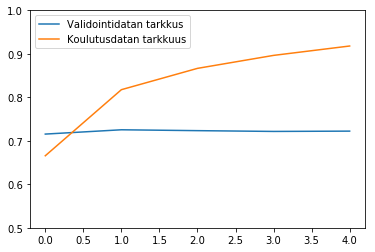

In [12]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tarkkuudeksi saatiin validointidatalla 72,6%, joka on huonompi kuin tukivektorikoneella tai Naive Bayesilla saatu tarkkuus. Kuviosta huomataan,ettei validointidatan tarkkuus parane toisen kierroksen jälkeen (x-akselin indeksi 0 vastaa ensimmäistä validointitulosta, joka lasketaan ensimmäisen kierroksen jälkeen). 

Näinkin yksinkertaisen neuroverkon koulutus vei koneellani noin 40 minuuttia. Neuroverkoilla olisi huikea selitysvoima, mutta niiden opettamiseen vaaditaan myös huikean paljon laskentatehoa. Tavallisella kotikoneella erilaisten yksikertaistenkin mallien koulutus ja niiden hyperparametrien virittäminen on helposti tuntien tai jopa päivien urakka. 

Koska nämä mallit ovat niin yksinkertaisia ja dataa on niinkin paljon (100 000 viestiä), neuroverkko tuntuu oppivan riittävästi jo ensimmäisillä kierroksilla. Ajan säästämiseksi tiputankin EarlyStoppingin patience-parametrin arvoon 1.

Kokeillaan lisätä solujen määrää 300:aan.

In [13]:
nodes1 = 300
model = create_model1(features, nodes1)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 100, batch_size=150, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc


0.7265

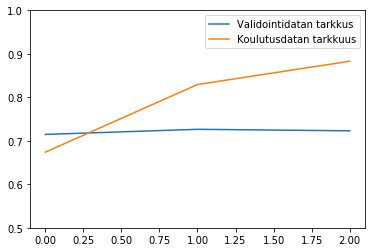

In [14]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tarkkuus parani vain hyvin vähän (nyt 72,7%, 124:llä solulla 72,6%). Kokeillaan seuraavaksi samaa, mutta muutetaan piirrevektoria niin, että jokainen vektorin luku voi saada vain arvon 0 tai 1. Eli mikäli kyseinen sana esiintyy vähintään kerran tekstissä, sanaa vastaava vektorin luku saa arvon 1.

In [15]:
count_vect = CountVectorizer(max_features=100000, binary=True)
count_vect.fit(X_train)

X_train_counts = count_vect.transform(X_train)
X_dev_counts = count_vect.transform(X_dev)
X_test_counts = count_vect.transform(X_test)

In [16]:
features = X_train_counts.shape[1]
nodes1 = 300
model = create_model1(features, nodes1)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc


0.7209

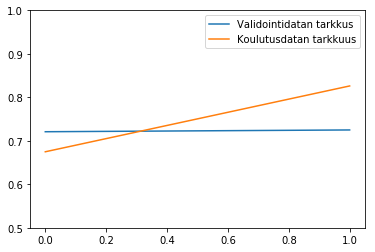

In [17]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tulos huononi hiukan. Puhdistetaan välillä muistia.

In [12]:
# Muistin puhdistus: tuhoaa nykyisen TF-graafin ja luo uuden.
from keras import backend as K
K.clear_session()

Kokeillaan seuraavaksi tf_idf-piirrematriisia.

In [4]:
count_vect = TfidfVectorizer(max_features=100000)
count_vect.fit(X_train)

X_train_counts = count_vect.transform(X_train)
X_dev_counts = count_vect.transform(X_dev)
X_test_counts = count_vect.transform(X_test)

In [34]:
features = X_train_counts.shape[1]
nodes1 = 300
model = create_model1(features, nodes1)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc

0.7436

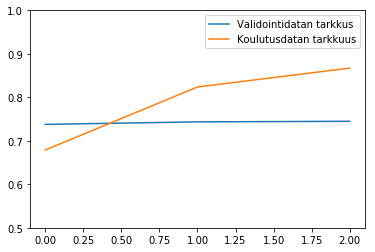

In [35]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Saatiin tähän mennessä paras tulos 74,4%

Pienennetään tf_idf-matriisia poistamalla laajasti esiintyvät (max_df=0.7) ja hyvin harvoissa dokumenteissa esiintyvät (min_df=0.0001) sanat. Otetaan mukaan myös 2- ja 3-grammit. Piirteitä on nyt yhteensä 63569:

In [38]:
count_vect = TfidfVectorizer(ngram_range=(1, 3), max_df=0.7, min_df=0.0001)
count_vect.fit(X_train)

X_train_counts = count_vect.transform(X_train)
X_dev_counts = count_vect.transform(X_dev)
X_test_counts = count_vect.transform(X_test)

In [40]:
features = X_train_counts.shape[1]
nodes1 = 300
model = create_model1(features, nodes1)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc

0.7108

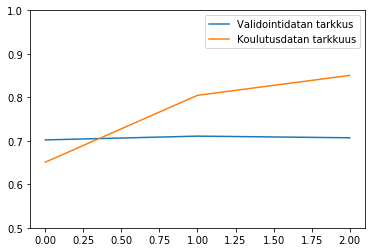

In [41]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tulos huononi jälleen. Kokeillaan vielä mallia jossa on kaksi piilotettua tasoa. 

In [21]:
count_vect = TfidfVectorizer(max_features=100000)
count_vect.fit(X_train)

X_train_counts = count_vect.transform(X_train)
X_dev_counts = count_vect.transform(X_dev)
X_test_counts = count_vect.transform(X_test)

In [44]:
features = X_train_counts.shape[1]
nodes1 = 256
nodes2 = 64
model = create_model2(features, nodes1, nodes2)

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc

0.7426

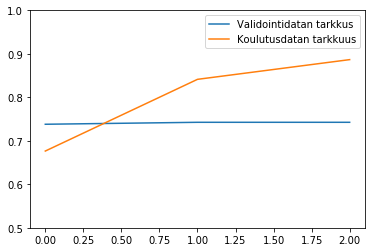

In [45]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tulokseksi saatiin 74,3%. Tähän mennessä paras validointitarkkuus 74,4% saatiin tf_idf-vektoreilla ja yhdellä piilotetulla kerroksella, jossa oli 300 solua. 

Tähän asti optimointialgoritmina on käytetty rmsprop-algoritmia sen oletusarvoisella oppimisnopeusparametrin arvolla 0.001. Kokeillaan pienentää parametrin arvo puoleen.

In [23]:
features = X_train_counts.shape[1]
model = models.Sequential()
model.add(layers.Dense(300, activation='relu', input_shape=(features,)))
model.add(layers.Dense(10, activation='softmax'))
rmsprop = optimizers.RMSprop(lr=0.0005)
model.compile(optimizer= rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc

0.7416

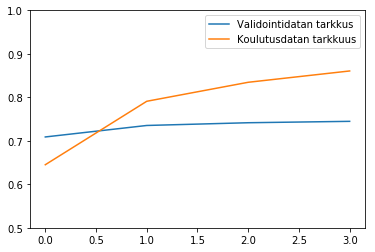

In [25]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Ainakaan näin pieni muutos oppimisnopeusparametrissä ei parantanut tulosta. Vaihdetaan optimointialgoritmi Adamiksi. RMSProp mukauttaa neuroverkon parametrien oppimisnopeutta keskimääräisen ensimmäisen momentin (keskiarvo) perusteella. Adam ottaa tämän lisäksi humioon myös gradienttien toiset momentit (varianssi). Käytetään Adamin oletusarvoisia parametriarvoja (learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False).

In [5]:
features = X_train_counts.shape[1]
model = models.Sequential()
model.add(layers.Dense(300, activation='relu', input_shape=(features,)))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc

0.7451

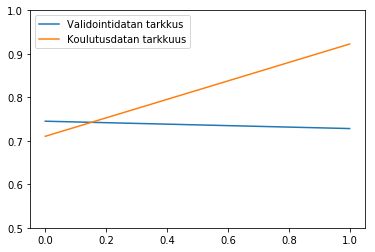

In [7]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Saatiin tähän asti paras validointitarkkuus 74,5%, mutta validointitarkkuus laskee jo heti ensimmäisen kierroksen jälkeen. Koitetaan pienentää oppimisnopeutta kymmenesosaan.

Ensemble-menetelmät perustuvat teoriaan, että kun yhdistetään eri luokittelijoita, joista jokainen ennustaa paremmin kuin satunnainen arvaaminen, satunnaiset virheet kumoavat toisensa ja oikeat päätökset vahvistuvat.  Yksi tapa luoda erilaisia luokittelijoita, on käyttää luokittelijoiden kouluttamiseen erilaisia otoksia koulutusdatasta. Neuroverkkojen tapauksessa käytännöllinen tapa muodostaa lukuisia erilaisia aliverkkoja on lisätä dropout-kerros, joka maskaa valitun osuuden kerroksen solmuista pois kertomalla ulostuloarvon nollalla. Lisätään myös tällainen dropout-kerros malliin.

Opetusajat alkavat olemaan jo niin pitkiä, että lisään myös opetuksen edistymisenseurannan näkyviin. Tämä tehdään asettamalla parametri verbose = 1.

In [13]:
features = X_train_counts.shape[1]
model = models.Sequential()
model.add(layers.Dense(300, activation='relu', input_shape=(features,)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(10, activation='softmax'))
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer= adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_counts, labels_train, epochs= 30, batch_size=100, 
                    validation_data=(X_dev_counts, labels_dev), verbose = 1, callbacks=[es])

_, val_acc = model.evaluate(X_dev_counts, labels_dev, verbose=0)
val_acc

Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - 952s 10ms/step - loss: 2.1428 - acc: 0.5306 - val_loss: 1.8973 - val_acc: 0.6800
Epoch 2/30
100000/100000 [==============================] - 970s 10ms/step - loss: 1.5832 - acc: 0.7279 - val_loss: 1.3889 - val_acc: 0.7138
Epoch 3/30
100000/100000 [==============================] - 947s 9ms/step - loss: 1.1194 - acc: 0.7814 - val_loss: 1.1109 - val_acc: 0.7312
Epoch 4/30
100000/100000 [==============================] - 956s 10ms/step - loss: 0.8527 - acc: 0.8162 - val_loss: 0.9671 - val_acc: 0.7412
Epoch 5/30
100000/100000 [==============================] - 947s 9ms/step - loss: 0.6842 - acc: 0.8479 - val_loss: 0.8854 - val_acc: 0.7495
Epoch 6/30
100000/100000 [==============================] - 948s 9ms/step - loss: 0.5675 - acc: 0.8703 - val_loss: 0.8364 - val_acc: 0.7540
Epoch 7/30
100000/100000 [==============================] - 947s 9ms/step - loss: 0.4763 - acc: 0.8924 - v

0.7549

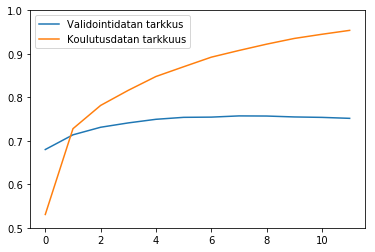

In [15]:
plt.ylim(0.5,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Saimme parhaan tuloksen 75,5%. Arvioidaan vielä parhaan mallin luotettavuus testidatalla.

In [28]:
_, val_acc = model.evaluate(X_test_counts, labels_test, verbose=1)
val_acc

10000/10000 [==============================] - 30s 3ms/step


0.736

Testidatalla tarkkudeksi saatiin 73,6%.

### 4.5 Neuroverkko käyttäen sanaupotuksia (word embeddings)
Sanaupotukset ovat sanan merkitystä kuvaavia realilukuarvoisia vektoreita. Perusideana on, että sanan merkitys voidaan määrittää sen perusteella, minkä muiden sanojen yhteydessä se esiintyy. Näin semanttisesti toisiaan lähellä olevat sanat sijoittuvat myös vektoriavaruudessa lähelle tosiaan.

Sanaupotuksia on mahdollista opettaa valmiilla neuroverkomalleilla omasta aineistosta. Tällaisia työkaluja ovat ainakin Googlen kehittämä word2vec, Facebookin kehittämä fastText ja Stanford Universityn kehittämä GloVe. Tämä vaatii kuitenkin suuren datamäärän sekä runsaasti laskentakapasiteettia. Siksi usein käytetäänkin valmiiksi opetettuja (jollakin kattavalla aineistolla) sanaupotuksia.

Suomenkielessä sanoilla on useita taivutusmuotoja ja sanajohdoksia. FastText sopii hyvin suomenkielisten sanojen vektoriesitysten mudostukseen, koska se hyödyntää mallissaan myös sanojen alimerkkijonoja.

Osoitteesta https://fasttext.cc/docs/en/crawl-vectors.html voi ladata FastTextin valmiit sanaupotusvektorit 157 kielelle. Olen tallentanut sieltä koneelleni suomekielisten sanojen vektoriesitykset tekstimuodossa. Ladataan tämä sanaupotusmalliksi.


In [7]:
embmodel=KeyedVectors.load_word2vec_format("cc.fi.300.vec.gz", binary=False)

In [8]:
embmodel.vectors.shape

(2000000, 300)

Mallissa on yhteensä kaksi miljoonaa sanaa. Jokainen matriisin rivi edustaa yhtä sanaa. Sarakkeiden lukumäärästä nähdään, että sanat esitetään 300-dimensioisen avaruuden vektoreina.

Tutkitaan hieman mallin ominaisuuksia. Sanojen läheisyys lasketaan käyttäen kosini samankaltaisuutta. Suure saa suurimman arvonsa 1, kun vektoreiden välinen kulma on 0, ja pienimmän arvon 0, kun vektorit ovat ortogonaalisia suhteessa toisiinsa. 

In [9]:
print("Lähimpänä sanaa 'peli' löytyvät sanat:")
print(embmodel.most_similar("peli",topn=10))
print()

print("Sanojen 'jalkapallo' ja 'jääkiekko' samanlaisuus:")
print(embmodel.similarity("jalkapallo", "jääkiekko"))
print("Sanojen 'jalkapallo' ja 'jää' samanlaisuus:")
print(embmodel.similarity("jalkapallo", "jää"))

Lähimpänä sanaa 'peli' löytyvät sanat:
[('15-peli', 0.7574991583824158), ('ohipeli', 0.7506250143051147), ('DS-peli', 0.7480830550193787), ('peli.', 0.7412402629852295), ('peruspeli', 0.7381929159164429), ('PSP-peli', 0.7369946241378784), ('GP-peli', 0.7369784116744995), ('perhepeli', 0.7339655160903931), ('puzzlepeli', 0.7338589429855347), ('puzzle-peli', 0.7330989241600037)]

Sanojen 'jalkapallo' ja 'jääkiekko' samanlaisuus:
0.71136767
Sanojen 'jalkapallo' ja 'jää' samanlaisuus:
0.1774352


Jotta nämä valmiit sanaupotusvektorit pystyttäisiin yhdistämään alkuperäisten tekstidokumenttiemme sanoihin, meidän pitää vektorisoida alkuperäiset tekstidokumentit uudella tavalla. Ensin koko korpuksen sanasto indeksoidaan. Sitten jokaisesta dokumentista muodostetaan lista kokonaislukuja niin, että jokainen dokumentin sana korvataan kyseistä sanaa vastaavalla indeksillä. Tämä voidaan tehdä helposti käyttämällä Kerasin Tokenizer-apuohjelmaluokkaa. Tietokoneeni rajallisen muistikapasiteetin vuoksi otetaan malliin mukaan vain 100 000 yleisintä sanaa.

In [29]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

Xseq_train = tokenizer.texts_to_sequences(X_train)
Xseq_dev = tokenizer.texts_to_sequences(X_dev)
Xseq_test = tokenizer.texts_to_sequences(X_test)

In [30]:
print(X_train[1000])
print(Xseq_train[1000])

Autohifikritiikki perustuu siihen , että äänentoiston asentajat eivät ymmärrä puhtaan äänen päälle , vaan rakentavat epätasapainoisia järjestelmiä . Ylilyödyt bassot ovat yleisimpiä ongelmia ja vain harva tekee äänentoiston kunnolla . Toinen tekijä on siinä , että monessa autossa perussetti on tarpeeksi pätevä . Kun auto pitää kovaa meteliä , niin laadukkaaseen äänentoistoon turha panostaa ellei panosta kunnon äänieristykseen .
[1070, 87, 4, 37809, 47099, 73, 354, 10786, 7593, 244, 26, 13196, 14669, 78199, 28, 31656, 521, 1, 18, 1907, 182, 37809, 492, 205, 2151, 2, 61, 4, 2911, 1420, 37810, 2, 331, 3808, 8, 269, 65, 935, 11681, 6, 47100, 519, 2779, 448, 7871, 381]


Yllä nähdään, miten ensimmäinen viesti on muutettu niitä vastaavien sanaindeksien listaksi.

Koska dokumenttien sisältämä sanamäärä vaihtelee, myös niistä muodostettuen sanaindeksilistojen pituus vaihtelee. Tokenizer aloittaa sanaston indeksoinnin luvusta 1. Indeksi 0 ei siis vastaa mitään sanaa, joten sitä voidaan käyttää "listan täytteenä" (padding), kun kaikista dokumenteista halutaan muodostaa keskenään saman pituisia listoja. 

Muodostetaan nyt kaikista dokumenteista (viesteistä) saman pituiset sanaindeksilistat lisäämällä loppuun vaadittava määrä indeksejä 0. tehdään tämä käyttäen Kerasin pad_sequences-luokkaa.

In [31]:
Xpad_train = pad_sequences(Xseq_train, padding='post')
print(Xpad_train[0])
max_words = len(Xpad_train[0])
print(max_words)

[62914 77475   148 ...     0     0     0]
1307


Tehdään validointi- ja testiaineistojen vektoreista saman pituisia kuin koulutusaineiston pisin viesti (1307 sanaa). Tallennetaan vektorit myöhempää käyttöä varten.

In [32]:
Xpad_dev = pad_sequences(Xseq_dev, maxlen=max_words, padding='post')
Xpad_test = pad_sequences(Xseq_test, maxlen=max_words, padding='post')
print(len(Xpad_dev[0]))

1307


In [33]:
np.save('Xpad_train.npy', Xpad_train)
np.save('Xpad_dev.npy', Xpad_dev)
np.save('Xpad_test.npy', Xpad_test)

Seuraavaksi muodostetaan matriisi, joka yhdistää viesteistä muodostetun sanaston sanat upotussanavektoreihin. Eli matriisin rivillä 1 on viesteistä muodostetun sanaston indeksiä 1 vastaavan sanan 'ja' 300-dimensioinen upotusvektori. Jos sanalle ei löydy upotusvektoria, sitä vastaavan vektorin kaikki luvut jäävät matriisissa arvoon 0.

In [15]:
embmatrix =  np.zeros((100001, 300))
count = 0
for word, i in word_index.items(): 
    if i < 100001:
        if word in embmodel.vocab:
            embmatrix[i] = embmodel.get_vector(word)
            count += 1

In [20]:
np.save('embmatrix.npy', embmatrix)

In [16]:
embmatrix[1]

array([ 6.85999990e-02,  7.13000000e-02, -3.77999991e-02, -1.22199997e-01,
       -4.28000018e-02, -1.84699997e-01,  2.77999993e-02, -4.28999998e-02,
        4.50500011e-01, -8.00000038e-03,  4.74999994e-02,  6.40000030e-02,
        6.49999976e-02, -9.53999981e-02, -2.07000002e-02,  1.76999997e-02,
        7.64999986e-02,  2.43999995e-02, -2.25000009e-02,  5.75999990e-02,
        2.14300007e-01,  3.68000008e-02, -7.81000033e-02, -3.77999991e-02,
        6.43000007e-02, -7.10000005e-03,  6.58000037e-02, -8.10000002e-02,
       -1.70800000e-01, -3.06000002e-02, -1.43700004e-01, -7.53000006e-02,
       -4.17999998e-02,  5.57000004e-02, -1.84200004e-01,  6.17000014e-02,
       -8.16000029e-02, -4.49999981e-03, -5.40999994e-02,  1.02000004e-02,
       -3.99999990e-04,  1.41700000e-01, -1.70000002e-03, -3.05000003e-02,
        3.84999998e-02, -5.71999997e-02, -1.47000002e-02, -5.90000022e-03,
       -4.34999987e-02, -3.75000015e-02,  2.19200000e-01,  1.53000001e-02,
        1.64999999e-02,  

In [19]:
 print('Upotusvektori löytyi ',count, ' sanalle.') 

Upotusvektori löytyi  86570  sanalle.


Nyt olemme valmiita muodostamaan upotusvektoreita hyödyntävän neuroverkon. Embedding-kerroksen 2D-tulosta ei pysty suoraan yhdistämään Dense-kerrokseen, joka käsittelee 1D-syötteitä. Tämän vuoksi Enbedded-kerroksen tulos täytyy muuntaa 1D:ksi joko litistämällä tulos Flatten-kerroksella tai käyttämällä GlobalMaxPool1D- tai GlobalAveragePool1D-kerroksia (palauttavat litistettävän dimension kaikkien piirteiden maksimin tai keskiarvon).

In [9]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=100001, 
                           output_dim=300, 
                           weights = [embmatrix],
                           input_length = 1307,
                           trainable=False ))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1307, 300)         30000300  
_________________________________________________________________
flatten_1 (Flatten)          (None, 392100)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                25094464  
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 55,095,414
Trainable params: 25,095,114
Non-trainable params: 30,000,300
_________________________________________________________________


In [11]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(Xpad_train, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(Xpad_dev, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(Xpad_dev, labels_dev, verbose=0)
val_acc

0.5815

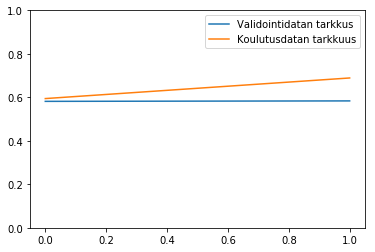

In [12]:
plt.ylim(0,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tuli harmillisen huono tulos. Lisätään malliin konvoluutiokerros embedding-kerroksen jälkeen ja korvataan Flatten-kerros GlobalMaxPool1D-kerroksella. Lisätään myös dropout-kerros ja kasvatetaan Early stopping-menetelmän patience-parametrin arvo viiteen, jolloin neuroverkon kouluttaminen loppuu vasta, kun validointitulos ei ole parantunut viimeisen viiden kierroksen aikana.

In [17]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=100001, 
                           output_dim=300, 
                           weights = [embmatrix],
                           input_length = 1307,
                           trainable=False ))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1307, 300)         30000300  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1303, 128)         192128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 30,201,334
Trainable params: 201,034
Non-trainable params: 30,000,300
__________________________________________________________

In [18]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(Xpad_train, labels_train, epochs= 10, batch_size=100, 
                    validation_data=(Xpad_dev, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(Xpad_dev, labels_dev, verbose=0)
val_acc

0.6941

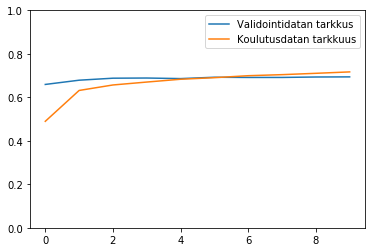

In [19]:
plt.ylim(0,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkuus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Tämän mallin koulutusajo kestikin kotikoneella jo yli 12 tuntia. Tarkkuudeksi saatiin validointidatalla 69.4%. Pienemmällä oppimisnopeusparamerin arvolla saatettaisiin päästä parempaan tulokseen. Koitetaan siis samaa mallia pienentämällä oppimisnopeus kymmenesosaan (lr=0.0001).

In [4]:
model = models.Sequential()
model.add(layers.Embedding(input_dim=100001, 
                           output_dim=300, 
                           weights = [embmatrix],
                           input_length = 1307,
                           trainable=False ))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1307, 300)         30000300  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1303, 128)         192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 30,201,334
Trainable params: 201,034
Non-trainable params: 30,000,300
__________________________________________________________

In [6]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(Xpad_train, labels_train, epochs= 30, batch_size=100, 
                    validation_data=(Xpad_dev, labels_dev), verbose = 1, callbacks=[es])

_, val_acc = model.evaluate(Xpad_dev, labels_dev, verbose=0)
val_acc

Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - 4609s 46ms/step - loss: 2.0552 - acc: 0.3080 - val_loss: 1.7739 - val_acc: 0.4897
Epoch 2/30
100000/100000 [==============================] - 4451s 45ms/step - loss: 1.6676 - acc: 0.4739 - val_loss: 1.4046 - val_acc: 0.5871
Epoch 3/30
100000/100000 [==============================] - 4449s 44ms/step - loss: 1.4290 - acc: 0.5512 - val_loss: 1.2471 - val_acc: 0.6191
Epoch 4/30
100000/100000 [==============================] - 4448s 44ms/step - loss: 1.3136 - acc: 0.5855 - val_loss: 1.1690 - val_acc: 0.6362
Epoch 5/30
100000/100000 [==============================] - 4444s 44ms/step - loss: 1.2438 - acc: 0.6094 - val_loss: 1.1196 - val_acc: 0.6494
Epoch 6/30
100000/100000 [==============================] - 4450s 45ms/step - loss: 1.1902 - acc: 0.6253 - val_loss: 1.0861 - val_acc: 0.6583
Epoch 7/30
100000/100000 [==============================] - 4468s 45ms/step - loss: 1.1529 - acc:

0.7012

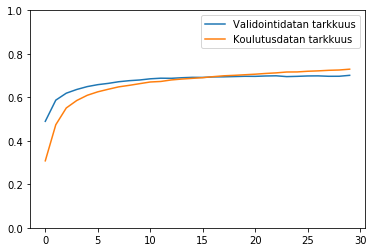

In [7]:
plt.ylim(0,1.0)
plt.plot(history.history["val_acc"],label="Validointidatan tarkkuus") 
plt.plot(history.history["acc"],label="Koulutusdatan tarkkuus")
plt.legend()
plt.show()

Paras validointitulos 70,1% saatiin viimeisellä kierroksella, joten tulos olisi voinut vielä hiukan parantua, mikäli koulutusta olisi jatkettu kauemmin. Mallin koulutus kesti näinkin yli 36 tuntia, joten neuroverkon hienosäätö tavallisella koneella alkaa käydä mahdottomaksi.

In [8]:
_, val_acc = model.evaluate(Xpad_test, labels_test, verbose=0)
val_acc

0.6854

Testidatalla tarkkuudeksi saatiin 68,5%. Tulos jäi huonommaksi kuin muilla menetelmillä. Sanaupotusvektorit oli koneeni muistirajoitteiden vuoksi käytössä vain 86570:lle sanalle, kun koko sanaston koko olisi ollut lähes 400 000. Tämä on todennäköisin syy sille, ettei sanaupotusvektoireita hyödyntämällä päästy parempaan tulokseen. Ilman sanaupotuksia koulutettu neuroverkko koulutettiin 100 000 sanalla ja sillä päästiin jo merkittävästi parempaan tarkkuutteen 73,6%.

### 4.7 Sanaupotuksia hyödyntävä konvoluutioneuroverkko CSC:n supertietokoneella
Kotikoneen kapasiteettirajoitteiden vuoksi sanaupotuksia hyödyntävien neuroverkkojen luokittelutarkkuus jäi edellä varsin pieneksi. Katsotaan, millaisiin tuloksiin pääsemme CSC:n supertietokoneen Puhtin avulla, kun malliin voidaan ottaa mukaan kaikki koulutusdatan sanat ja hyperparametrien optimointikin on mahdollista järkevässä ajassa.

Muodostetaan uudelleen matriisi, joka yhdistää koulutusaineiston viesteistä muodostetun sanaston sanat upotussanavektoreihin. Tällä kertaa upotussanamatrisiin otetaan mukaan kaikki sanat.

In [5]:
embmodel=KeyedVectors.load_word2vec_format("cc.fi.300.vec.gz", binary=False)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

Xseq_train = tokenizer.texts_to_sequences(X_train)
Xseq_dev = tokenizer.texts_to_sequences(X_dev)
Xseq_test = tokenizer.texts_to_sequences(X_test)

In [7]:
embmatrix_all =  np.zeros((len(word_index) + 1, 300))
count = 0
for word, i in word_index.items(): 
    if word in embmodel.vocab:
        embmatrix_all[i] = embmodel.get_vector(word)
        count += 1

In [10]:
np.save('embmatrix_all.npy', embmatrix_all)

In [11]:
print('Koulutusdatassa on',len(word_index), 'erilaista sanaa. ''Upotusvektori löytyi', count, 'sanalle eli', 
     '%.2f' % (100*count/len(word_index)), 'prosentille.')

Koulutusdatassa on 399349 erilaista sanaa. Upotusvektori löytyi 212960 sanalle eli 53.33 prosentille.


Tämä on huomattavasti enemmän kuin aikaisemmassa matriisissa, jossa upotusvektorit löytyi vain 86570:lle sanalle. 

Jos omat käyttöoikeudet on olemassa, Puhtiin saa SSH-yhteyden Windows-koneella esim käyttämällä PuTTYä (https://putty.org/). Tiedostojen siirtelyyn oman koneen ja Puhtin välillä käytin FileZillaa (https://filezilla-project.org/). CSC:n kattavat Linux-ohjeet löytyvät täältä: https://research.csc.fi/csc-guide-linux-basics-for-csc.

Puhti käyttää SLURM-ajonhallintajärjestelmää. Työn saamiseksi ajoon, tarvitaan määrämuotoinen .sh-päätteinen eräajotiedosto, joka lähetetään töiden aikatauluttajalle komennolla sbatch. Eräajotiedoston voi kirjoittaa tavallisella tekstieditorilla (käytin tässä Nanoa). 

Eräajotiedoston sisältö:

In [ ]:
#!/bin/bash
#SBATCH --job-name=testi
#SBATCH --account=Project_XXX
#SBATCH --partition=gpu
#SBATCH --time=01:00:00
#SBATCH --mem-per-cpu=2G
#SBATCH --gres=gpu:v100:1

module purge
module load tensorflow
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

python CNN.py

Ajetaan supertietokoneella seuraavaa koodia (yllä tiedosto CNN.py) vastaava osuus erilaisilla ohjausparametrien arvoilla: 

In [ ]:
max_words = len(Xpad_train[0])
different_words = embmatrix_all.shape[0]
dim = embmatrix_all.shape[1]

model = models.Sequential()
model.add(layers.Embedding(input_dim=different_words, 
                           output_dim=dim, 
                           weights = [embmatrix_all],
                           input_length = max_words,
                           trainable=False ))
model.add(layers.Conv1D(filters, kernel_size, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(dim1, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
adam = optimizers.Adam(lr=lr)
model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience= patience, verbose=0, 
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(Xpad_train, labels_train, epochs= epochs, batch_size= batch_size, 
                    validation_data=(Xpad_dev, labels_dev), verbose = 0, callbacks=[es])

_, val_acc = model.evaluate(Xpad_dev, labels_dev, verbose=0)
print('Tarkkuus validointidatalla', val_acc)

_, val_acc = model.evaluate(Xpad_test, labels_test, verbose=0)
print('Tarkkuus testidatalla', val_acc)


1. Ajetaan ensin samoilla ohjausparametreilla kuin viimeisin paras tulos:
filters = 128,
kernel_size = 5,
lr = 0.0001,
patience = 2,
epochs = 100,
batch_size = 100,
dim1 = 64. Tällä kertaa mallissa on siis mukana kaikki sanat, joille löytyi upotusvektorit.

        Tulos: tarkkuus validointidatalla 72,4%, tarkkuus testidatalla 71,1%.

2. Sama ilman ensimmäistä Dense-kerrosta:

        Tulos: tarkkuus validointidatalla 72,5%, tarkkuus testidatalla 71,5%.
        Tulos parani, joten jatketaan tämän yksinkertaisemman mallin optimoimista.

3. Edellinen, mutta trainable-arvolla 'True' eli nyt upotussanavektoreita edelleenkoulutetaan testiaineistolla:

        Tulos: tarkkuus validointidatalla 75,9%, tarkkuus testidatalla 74,2%.
        Saimme tähän mennessä parhaan tuloksen. 
        Katsotaan, saadaanko tulosta vielä paremmaksi hyperparametrejä (filters, kernel_size ja lr) säätämällä.

4. Edellinen, kernel_size = 4 ja 3:

        Tulos, kernel_size = 4: tarkkuus validointidatalla 75,8%, tarkkuus testidatalla 74,1%.
        Tulos, kernel_size = 3: tarkkuus validointidatalla 75,1%, tarkkuus testidatalla 73,7%.
        Tulokset huononivat kernel_sizeä pienennettäessä.

5. Tuplataan filters = 256, kernel_size = 5, 4 ja 3:

        Tulos, kernel_size = 5: tarkkuus validointidatalla 76,5%, tarkkuus testidatalla 74,2%.
        Tulos, kernel_size = 4: tarkkuus validointidatalla 76,2%, tarkkuus testidatalla 74,3%.
        Tulos, kernel_size = 3: tarkkuus validointidatalla 76,2%, tarkkuus testidatalla 74,4%.
        Isommalla filters-arvolla saatiin parempia tuloksia.
        
6. Edellinen (filters = 256, kernel_size = 5, 4 ja 3), puolitetaan lr = 0,00005:

        Tulos, kernel_size = 5: tarkkuus validointidatalla 76,3%, tarkkuus testidatalla 74,4%.
        Tulos, kernel_size = 4: tarkkuus validointidatalla 76,0%, tarkkuus testidatalla 74,2%.
        Tulos, kernel_size = 3: tarkkuus validointidatalla 75,8%, tarkkuus testidatalla 73,9%.
        Oppimisnopeutta säätelevän lr-parametrin puolittaminen ei parantanut tuloksia.
        
        
Jotta lopullisen mallin testidata pysyisi puolueettomana, sen perusteella laskettuja tarkkuusarvoja ei voi käyttää parhaan mallin valitsemiseen. Kun paras malli valitaan validointidatan perusteella, paras malli saatiin koulutettua arvoilla:
filters = 256,
kernel_size = 5,
lr = 0.0001,
patience = 2,
epochs = 100,
batch_size = 100. Tämän mallin tarkkuudeksi testidatalla saatiin 74,2%

Näiden 11 neuroverkon opettaminen supertietokoneella kesti yhteensä muutaman tunnin. Yhdenkään näin ison mallin (sanaupotusvektorit yli 200 000 sanalle) opettaminen ei olisi ollut mahdollista kotikoneellani. Suurimman lähinnä näitä vastaavan neuroverkon opettaminen kesti kotikoneella yli 36 tuntia.

## 5. Yhteenveto eri luokittelumenetelmistä
Olemme edellä kouluttaneet luokittelijoita erilaisilla menetelmillä: 
* Naive Bayes: validointidatalla tarkkuus 73.1%, testiaineistolla 71,6%.
* Tukivektorikone: validointidatalla tarkkuus 74,0%, testiaineostolla 72,0%
* Neuroverkko 100000 sanalla: validointidatalla tarkkuus 75,5%, testiaineistolla 73,6%.
* Konvoluutioneuroverkko esikoulutetuilla sanaupotuksilla, 100000 sanalla: validointidatalla tarkkuus 70,1%, testiaineistolla 68,5%.
* Konvoluutioneuroverkko esikoulutetuilla sanaupotuksilla, kaikilla sanoilla, sanaupotusten edelleenkoulutuksella: validointidatalla tarkkuus 76,5%, testiaineistolla 74,2%.

Paras tulos (testiaineistolla evaluoitu tarkkuus 74,2%) saavutettiin käyttäen konvoluutioneuroverkkoa esikoulutetuilla sanaupotuksilla, jossa neuroverkko vielä edelleenkoulutti sanaupotuksia. Tämän mallin kouluttaminen ei ollut mahdollista kotikoneella, joten siihen käytettiin CSC:n supertietokone Puhtia.

## Kiitokset
Olen tehnyt tämän työkirjan erikoistyönä osana Turun yliopiston Tekoälyn maisteriohjelmaa. Lämpimät kiitokset ohjaajalleni apulaisprofessori Sampo Pyysalolle, joka kannusti mm. opettelemaan Puhtin käyttöä!

Espoossa 31.12.2019 

Marita Risku, marita.h.risku@utu.fi